In [1]:
from lib.am_utils import *
import lib.consts as c
import matplotlib.pyplot as plt
%matplotlib widget
pd.set_option('display.width', 1000)

#### The Hamiltonian
\begin{equation}
H=H_\text{rot}+H_\text{hf}+H_\text{S}+H_\text{Z}
\end{equation}
where
\begin{equation}
H_\text{rot} = B_v\mathbf{N}^2-D_v\mathbf{N}^2\mathbf{N}^2
\end{equation}

\begin{equation}
H_\text{hf} = \sum_{i=1}^2\mathbf{V}_i\cdot\mathbf{Q}_i + \sum_{i=1}^2c_i\mathbf{N}\cdot\mathbf{I}_i + c_3\mathbf{I}_i\cdot\mathbf{T}\cdot\mathbf{I}_2+c_4\mathbf{I}_1\cdot\mathbf{I}_2
\end{equation}

\begin{equation}
H_S = -\mathbf{\mu}\cdot\mathbf{E}
\end{equation}

\begin{equation}
H_Z = -g_r\mu_N\mathbf{N}\cdot\mathbf{B} - \sum_{i=1}^2g_i\mu_N\mathbf{I}_i\cdot\mathbf{B}(1-\sigma_i)
\end{equation}

#### Parameters

In [2]:
# make everything in kHz
p0 = {'I1': 3/2,
      'I2': 7/2,
      'N': arange(0,1),
      'g1': 1.834,
      'g2': 0.738,
      'Bv': 0.490173*1e6, # MHz
      'eQq1': -0.80929*1e3, # MHz
      'eQq2': 0.05998*1e3, # MHz
      'sig1': 3531 / 1e6, # ppm
      'sig2': 6367 / 1e6, # ppm
      'c1': 29.4*1e-3, # Hz
      'c2': 194.1*1e-3, # Hz
      'c3': 192.4*1e-3, # Hz
      'c4': 19.019, # Hz
      'gr': 0.0062, # 0.0144 ##
      'muE': 1.25*3.33564*1e-28/c.h / 1e3, # D
      'muN': 5.050783699e-27 * 1e-4 * 1e-3/ c.h, # J/T
      'alpha_p': 2020+1997, # 1997*3/2, # 1872.1153,
      'alpha_s': (2*2020-1997)/2, # 0, # 467.0375,
      'E_td_00': np.linspace(0,0,1), # 1000
      'trap_pol': np.array([[0],[1],[0]]),
      'E_dc': np.array([0,0,0]), # V/cm
      'B': np.linspace(0,0,1)}

#### Create Hamiltonian
Everything ultimately in uncoupled basis

In [3]:
def dm_ops_sph(b,j='n'):
    _,_,delta_spec = get_spectators(b,[j,'m_'+j],mat=True)
    
    f1 = b_op(lambda b1,b2,j: (-1)**(b1['m_'+j])*np.sqrt((2*b1[j]+1)*(2*b2[j]+1)), b, 0,j) 
    f2 = b_op(lambda b1,b2,j: py3nj.wigner3j(b1[j], int(2*1), b2[j],
                                             0,     0,        0), b,1,j)
    
    cg_z = b_op(lambda b1,b2,j,q: py3nj.wigner3j(b1[j],    int(2*1),   b2[j],
                                              -b1['m_'+j], int(2*q), b2['m_'+j]), b,1,j,0)
    cg_r1 = b_op(lambda b1,b2,j,q: py3nj.wigner3j(b1[j],   int(2*1),   b2[j],
                                              -b1['m_'+j], int(2*q), b2['m_'+j]), b,1,j,1)
    cg_r2 = b_op(lambda b1,b2,j,q: py3nj.wigner3j(b1[j],   int(2*1),   b2[j],
                                              -b1['m_'+j], int(2*q), b2['m_'+j]), b,1,j,-1)
        
    M_z = delta_spec*f1*f2*cg_z
    M_r1 = delta_spec*f1*f2*cg_r1 # sig+
    M_r2 = delta_spec*f1*f2*cg_r2 # sig-

    return (M_r2,M_z,M_r1)

def H_mol(p):
    
    # create basis
    b_uc = am_basis([['i1',p['I1'],1],['i2',p['I2'],1],['n',p['N'],1]])
    b_sc, M_uc2sc = couple_basis(b_uc,['i1','i2','i'])
    b_fic, M_uc2fic = ([], [])
    for i,f in zip(['i1','i2'],['f1','f2']):
        b_t, M_t = couple_basis(b_uc,[i,'n',f])
        b_fic.append(b_t)
        M_uc2fic.append(M_t)
    b_fc, M_sc2fc = couple_basis(b_sc,['i','n','f'])
    M_uc2fc = M_sc2fc@M_uc2sc    
    

    H_hf_eQi_fic, H_hf_eQi_fc, H_hf_eQi_uc = ([],[],[])
    for ind,j in enumerate(zip(['i1','i2'],['f1','f2'])):
        i,n,f = (j[0],'n',j[1])
        v = b_fic[ind].v.copy()
        C = np.diag(op(b_fic[ind],i+'*'+n+','+f))
        H_hf_eQi_fic.append(np.diag(((3*C*C + 3/2*C - v[i]*(v[i]+1)*v[n]*(v[n]+1)) /
                      (2*v[i]*(2*v[i]-1)*(2*v[n]-1)*(2*v[n]+3)))))
        #H_hf_eQi_fic.append(np.diag(((3/2*C*(2*C+1) - v[i]*(v[i]+1)*v[n]*(v[n]+1)) /
        #              (2*v[i]*(2*v[i]-1)*(2*v[n]-1)*(2*v[n]+3)))))
        H_hf_eQi_uc.append(np.transpose(M_uc2fic[ind])@H_hf_eQi_fic[ind]@M_uc2fic[ind])
        H_hf_eQi_fc.append(M_uc2fc@np.transpose(M_uc2fic[ind])@H_hf_eQi_fic[ind]@
                             M_uc2fic[ind]@np.transpose(M_uc2fc))
    H_hf_eQ_uc = - p['eQq1']*H_hf_eQi_uc[0] - p['eQq2']*H_hf_eQi_uc[1]

    H_rot_uc = p['Bv'] * op(b_uc,'n^2')
    H_z_rot_uc = -p['gr']*p['muN'] * op(b_uc,'m_n')
    H_z_nuc_uc = -p['g1']*p['muN']*(1-p['sig1']) * op(b_uc,'m_i1') \
                    -p['g2']*p['muN']*(1-p['sig2']) * op(b_uc,'m_i2')

    H_hf_sr_uc = (p['c1'] * np.transpose(M_uc2fic[0])@op(b_fic[0],'i1*n,f1')@M_uc2fic[0] + \
                  p['c2'] * np.transpose(M_uc2fic[1])@op(b_fic[1],'i2*n,f2')@M_uc2fic[1])
    H_hf_ss_uc = p['c4'] * np.transpose(M_uc2fc)@op(b_fc,'i1*i2,i')@M_uc2fc
    
    def H_ls(b,a_p,a_s,E00,pol):
        
        def rot_state_op(b,M):
            Mrot = b_op(lambda b1,b2: ((b1['n']==0)&(b2['n']==0))*0 + 
            (((b1['n']==1)&(b2['n']==1)&(b1['m_n']==-1)&(b2['m_n']==-1))*M[0,0] +
             ((b1['n']==1)&(b2['n']==1)&(b1['m_n']==-1)&(b2['m_n']==0))*M[0,1] +
             ((b1['n']==1)&(b2['n']==1)&(b1['m_n']==-1)&(b2['m_n']==1))*M[0,2] +
             ((b1['n']==1)&(b2['n']==1)&(b1['m_n']==0)&(b2['m_n']==-1))*M[1,0] +
             ((b1['n']==1)&(b2['n']==1)&(b1['m_n']==0)&(b2['m_n']==0))*M[1,1] +
             ((b1['n']==1)&(b2['n']==1)&(b1['m_n']==0)&(b2['m_n']==1))*M[1,2] +
             ((b1['n']==1)&(b2['n']==1)&(b1['m_n']==1)&(b2['m_n']==-1))*M[2,0] +
             ((b1['n']==1)&(b2['n']==1)&(b1['m_n']==1)&(b2['m_n']==0))*M[2,1] +
             ((b1['n']==1)&(b2['n']==1)&(b1['m_n']==1)&(b2['m_n']==1))*M[2,2]),b,0)
            return Mrot
        
        _,_,delta_spec = get_spectators(b,['n','m_n'],mat=True)
        a_00 = 1/3 * (a_p + 2*a_s)
        
        a_23 = (2*a_p+3*a_s)/5
        a_32 = (3*a_p+2*a_s)/5        
        a_14 = (a_p+4*a_s)/5
        a_11 = (a_p-a_s)/5
        
        MM = np.zeros((3,3,3,3),dtype = 'complex_')
        MM[0,0] = np.array([[a_23,0,0],[0,a_23,0],[0,0,a_14]])
        MM[0,1] = np.array([[0,0,1j*a_11/np.sqrt(2)],[0,0,a_11/np.sqrt(2)],[1j*a_11/np.sqrt(2),a_11/np.sqrt(2),0]])
        MM[0,2] = np.array([[a_11,-1j*a_11,0],[-1j*a_11,-a_11,0],[0,0,0]])
        MM[1,0] = np.array([[0,0,-1j*a_11/np.sqrt(2)],[0,0,a_11/np.sqrt(2)],[-1j*a_11/np.sqrt(2),a_11/np.sqrt(2),0]])
        MM[1,1] = np.array([[a_14,0,0],[0,a_14,0],[0,0,a_32]])
        MM[1,2] = np.array([[0,0,-1j*a_11/np.sqrt(2)],[0,0,-a_11/np.sqrt(2)],[-1j*a_11/np.sqrt(2),-a_11/np.sqrt(2),0]])
        MM[2,0] = np.array([[a_11,1j*a_11,0],[1j*a_11,-a_11,0],[0,0,0]])
        MM[2,1] = np.array([[0,0,1j*a_11/np.sqrt(2)],[0,0,-a_11/np.sqrt(2)],[1j*a_11/np.sqrt(2),-a_11/np.sqrt(2),0]])
        MM[2,2] = np.array([[a_23,0,0],[0,a_23,0],[0,0,a_14]])   
        MM = np.einsum('ijkl->klij',MM)
        for i in range(3):
            for j in range(3):
                np.fill_diagonal(MM[i,j,:,:],np.diagonal(MM[i,j])-a_00)        
        if pol.shape == (3,1):
            P = np.einsum('ijkl,jm->ikl',MM,pol)
            Q = np.einsum('ij,jlm->ilm',np.conjugate(pol.T),P)
        else:
            P = np.einsum('ijkl,jm->ikl',MM,pol.T)
            Q = np.einsum('ij,jlm->ilm',np.conjugate(pol),P)
        Q = Q / np.linalg.norm(pol)
        mat = rot_state_op(b,Q[0,:])
        
        return delta_spec*mat*E00/a_00     

    H_ls_uc = -H_ls(b_uc,p['alpha_p'],p['alpha_s'],1,p['trap_pol'])
    
    if np.linalg.norm(p['E_dc']) > 0.001:
        M_r2,M_z,M_r1 = dm_ops_sph(b_uc)
        M_x = (M_r1 + np.conjugate(M_r2.T))/np.sqrt(2)
        M_y = (M_r1 - np.conjugate(M_r2.T))*1j/np.sqrt(2)
        H_S_uc = - p['muE'] * (p['E_dc'][0] * M_x + p['E_dc'][1] * M_y + p['E_dc'][2] * M_z)
    else:
        H_S_uc = 0
    
    if not(p['B'].shape[0] > 1 & p['E_td_00'].shape[0] > 1):
        H_B_tot_uc = (H_rot_uc + H_hf_sr_uc + H_hf_ss_uc + H_hf_eQ_uc + H_ls_uc*p['E_td_00'][:, np.newaxis, np.newaxis] +
            (H_z_rot_uc + H_z_nuc_uc) * p['B'][:, np.newaxis, np.newaxis]) + H_S_uc
    else:
        raise ValueError('cannot scan multiple axes')
        
    return np.real(H_B_tot_uc), b_uc

Helper functions

In [4]:
def map2basis(Tv):
    # finds the "closest" uncoupled basis index value
    M = np.zeros(Tv.shape)
    inds = []
    for j in range(Tv.shape[0]):
        v = Tv[:,j]
        v_amp = np.abs(v)
        ind = np.argmax(v_amp)
        M[ind,j] = 1
        inds.append(ind)
    return M, np.array(inds)

def disp_vec(buc, Evv, qn_uc, b_print=True):
    # display components corresponding to uc basis
    if type(qn_uc) == list:
        _,inds_vind2uc = map2basis(Evv)
        uc_ind = b_uc.get_ind(*qn_uc)[0]
        ev_ind = np.where(inds_vind2uc==uc_ind)[0][0]
        vec_amps = Evv[:,ev_ind] * Evv[:,ev_ind]
        vec_amps0 = Evv[:,ev_ind]
        amp_argsort = np.squeeze(np.argsort(-vec_amps,axis=0))
        pos = np.argmax(np.squeeze(-np.sort(-vec_amps,axis=0)) < 0.0001)
        ddf = b_uc.v.loc[amp_argsort[0:pos],['m_i1','m_i2','n','m_n']]
        ddf['amps'] =  np.squeeze(vec_amps0[amp_argsort[0:pos]])
    elif type(qn_uc) == int:
        vec_amps = Evv[:,qn_uc] * Evv[:,qn_uc]        
        vec_amps0 = Evv[:,qn_uc]
        amp_argsort = np.squeeze(np.argsort(-vec_amps,axis=0))
        pos = np.argmax(np.squeeze(-np.sort(-vec_amps,axis=0)) < 0.0001)
        ddf = b_uc.v.loc[amp_argsort[0:pos],['m_i1','m_i2','n','m_n']]
        ddf['amps'] =  np.squeeze(vec_amps0[amp_argsort[0:pos]])       
        ev_ind = qn_uc
    if b_print:
        print('Ev index: ' + str(ev_ind))    
        print(ddf)
    return ev_ind

def get_max_ind(v):
    return np.argmax(np.abs(v),axis=0)

def calc_eig(H):
    E0, Ev0 = np.linalg.eig(H)
    E0 = np.real(E0)
    
    if Ev0.shape[0] == 1:
        Ev0 = np.squeeze(Ev0)
    else:
        sort_ind = np.argsort(E0,axis=1)
        E0 = np.take_along_axis(E0,sort_ind,axis=1)
        Ev0 = np.take_along_axis(Ev0,sort_ind[:,None,:],axis=2)
    return E0, Ev0

In [5]:
def calc_uwave(E,Ev,b_uc,ss):
    
    def map2roteig(Tv, b_uc):
        inds = np.zeros(Tv.shape[0])
        for j in range(Tv.shape[0]):
            v = Tv[:,j]
            v_amp = np.abs(v)
            ind = np.argmax(v_amp)
            if b_uc.v.loc[ind,'m_n'] == 0:
                inds[j] = 0
            elif b_uc.v.loc[ind,'m_n'] == 1 or b_uc.v.loc[ind,'m_n'] == -1:
                v_amp[ind] = 0
                ind2 = np.argmax(v_amp)
                if np.sign(v[ind])*np.sign(v[ind2]) > 0:
                    inds[j] = 1
                else:
                    inds[j] = -1
        return inds
    
    sind = disp_vec(b_uc, Ev0, ss)    
    
    H_dm_uc = dm_ops_sph(b_uc)
    H_dm_v = []
    for i in range(3):
        H_dm_v.append(np.transpose(Ev)@H_dm_uc[i]@Ev)
                
    thresh = 0.00001
    all_ind = np.array([],dtype=np.int8)
    all_ind_uc = np.array([],dtype=np.int8)
    vals = np.empty([3],dtype=np.int8)
    vals_norm = np.array([],dtype=np.int8)
    pols = ['sig-','pi','sig+']
    trans_type = []

    mat_el = (H_dm_v[0][sind,:]**2+H_dm_v[1][sind,:]**2+H_dm_v[2][sind,:]**2)
    ind = (np.argwhere(np.abs(mat_el) > thresh))
    all_ind = np.append(all_ind,ind)
    all_ind_uc = np.append(all_ind_uc,get_max_ind(Ev[:,ind]))    
    mat_el_all = np.array([H_dm_v[0][sind,:],H_dm_v[1][sind,:],H_dm_v[2][sind,:]])
    for i in ind:
        vals = np.vstack([vals, np.squeeze(mat_el_all[:,i])])
        vals_norm = np.append(vals_norm,mat_el[i])
    vals = vals[1:,:]
    
    rot_inds = map2roteig(Ev, b_uc)

    df = b_uc.v.loc[all_ind_uc,['m_i1','m_i2','n','m_n']]
    # df['m_n'] = df['m_n']
    df['mF'] = df[['m_i1','m_i2','m_n']].sum(axis=1)
#     df['rot'] = pd.Series(rot_inds)
    df[['sig-','pi','sig+']] = pd.DataFrame(index=df.index,data=vals).applymap('{:,.5f}'.format)
    df['mat_el_abs'] = np.abs(vals_norm)
    # pols = ['sig-','pi','sig+']
    #df['pol'] = trans_type

    
    df['E [kHz]'] = E[0,all_ind] - E[0,all_ind[0]]
    df['rot'] = rot_inds[all_ind]
    df['v_ind'] = all_ind
    print(df.sort_values(['mat_el_abs'],ascending=False).drop(['mat_el_abs'],axis=1))
    #df['cost'] = df['cost'].map('${:,.2f}'.format)
    #print(df)


#### B-field dependence, no light shifts

In [6]:
p = p0.copy()
p['B'] = np.linspace(0,250,100)
H_B,_ = H_mol(p)

E0, Ev0 = calc_eig(H_B)

Text(0, 0.5, '$E$ [MHz]')

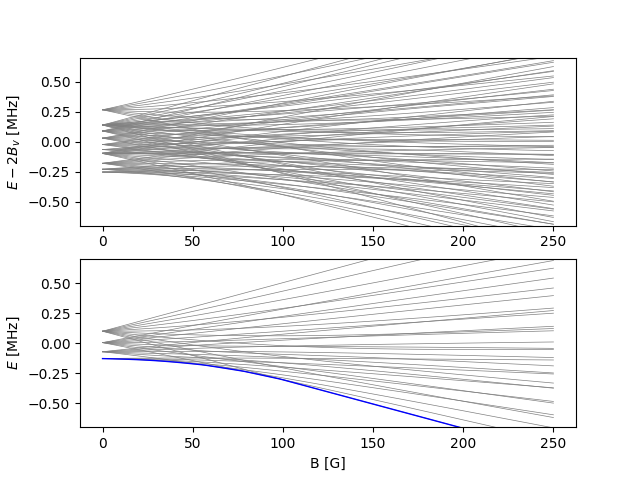

In [7]:
plt.close()
plt.figure(1)
B0 = p['B']
ax2 = plt.subplot(211)
pt2 = ax2.plot(B0,(E0-2*p['Bv'])/1e3,color='gray',linewidth=0.5)
# pt_gs = ax2.plot(B0,Egs-2*Bv,color='blue',linewidth=0.5)
plt.ylim(-.7,.7)
plt.ylabel('$E - 2B_v$ [MHz]')
ax1 = plt.subplot(212)
pt = ax1.plot(B0,E0/1e3,color='gray',linewidth=0.5)
# pt_gs = ax1.plot(B0,Egs/1e3,color='blue',linewidth=1)
pt_gs = ax1.plot(B0,E0[:,0]/1e3,color='blue',linewidth=1)
plt.ylim(-.7,.7)
plt.xlabel('B [G]')
plt.ylabel('$E$ [MHz]')
# plt.xlim(0,80)

### Consider light shifts



#### Estimate trap depth for ground state NaCs.

For 1064nm trap, polarizability for Cs is 1163$a_0^3$, while NaCs is 936$a_0^3$. For Cs, have roughly 1mK/V in terms of servo setpoint. We typically create the g.s. molecules at 0.25V --> 250$\mu$K trap for Cs, which corresponds to roughly 200$\mu$K for NaCs. With 20MHz/mK, that corresponds to ~4MHz in frequency units.

#### Differential light shift with linear polarization as in the experiment right now

In [92]:
p = p0.copy()
p['E_td_00'] = np.linspace(0,5000,100)
p['B'] = np.linspace(181.5,181.5,1)
p['trap_gamma'] = np.array([[0],[1],[0]])
# p['alpha_p'] = np.arccos(1/3)/2
H_B,b_uc = H_mol(p)

E0, Ev0 = calc_eig(H_B)

Text(0, 0.5, '|N=1> differential shift [MHz]')

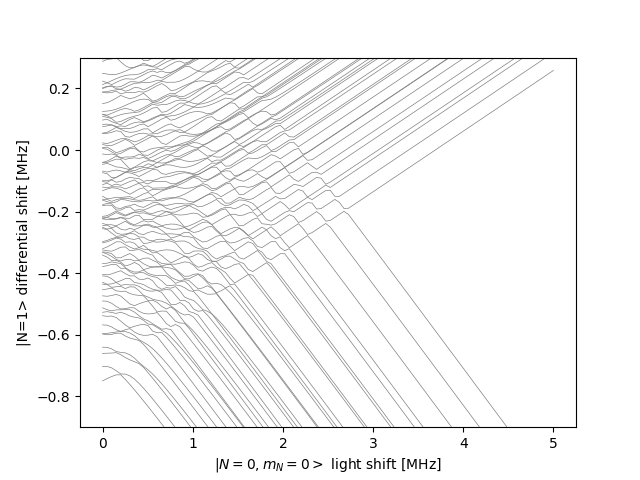

In [93]:
plt.close()
plt.figure(1)
x = p['E_td_00']/1e3
plt.plot(x,(E0-2*p['Bv'])/1e3,color='gray',linewidth=0.5)
# pt_gs = ax2.plot(B0,Egs-2*Bv,color='blue',linewidth=0.5)
plt.ylim(-.9,.3)
plt.xlabel('$|N=0,m_N=0>$ light shift [MHz]')
plt.ylabel('|N=1> differential shift [MHz]')

(-0.9, -0.4)

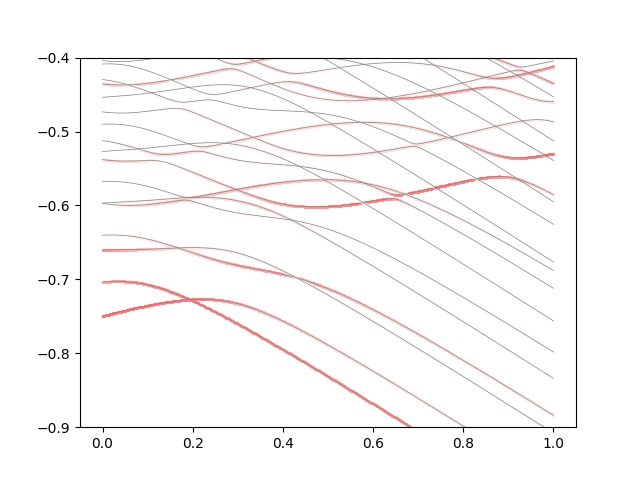

In [84]:
def calc_uwave_vals(E,Ev,b_uc,ss):
    
    def map2roteig(Tv, b_uc):
        inds = np.zeros(Tv.shape[0])
        for j in range(Tv.shape[0]):
            v = Tv[:,j]
            v_amp = np.abs(v)
            ind = np.argmax(v_amp)
            if b_uc.v.loc[ind,'m_n'] == 0:
                inds[j] = 0
            elif b_uc.v.loc[ind,'m_n'] == 1 or b_uc.v.loc[ind,'m_n'] == -1:
                v_amp[ind] = 0
                ind2 = np.argmax(v_amp)
                if np.sign(v[ind])*np.sign(v[ind2]) > 0:
                    inds[j] = 1
                else:
                    inds[j] = -1
        return inds
    
    sind = disp_vec(b_uc, Ev[0], ss, b_print=False)    
    
    H_dm_uc = dm_ops_sph(b_uc)
    H_dm_v_all = []
    for i in range(3):
        H_dm_v = np.zeros(Ev.shape[0:2])
        for n, vv in enumerate(Ev):
            H_dm_v[n,:] = (np.transpose(vv)@H_dm_uc[i]@vv)[sind,:]
        H_dm_v_all.append(H_dm_v)

    return H_dm_v_all # H_dm_v[:][sind,:]

def color_map_blue(norm_val):
    return (1-np.exp(np.log(norm_val)),1-np.exp(np.log(norm_val)),1)
def color_map_red(norm_val):
    return (1,1-np.exp(np.log(norm_val)),1-np.exp(np.log(norm_val)))

dm_val = calc_uwave_vals(E0,Ev0,b_uc,[['m_i1',1.5],['m_i2',3.5],['n',0],['m_n',0]])
    
plt.close()
plt.figure(1)
x = p['E_td_00']/1e3
plt.plot(x,(E0-2*p['Bv'])/1e3,color='gray',linewidth=0.5)
for i,xx in enumerate(x):
    dm_this = dm_val[1][i,:] # pi polarization for now
    inds = np.argwhere(np.abs(dm_this) > 0.001)
    for j in inds:
        plt.scatter(xx,(E0[i,j]-2*p['Bv'])/1e3,color=color_map(np.abs(dm_this)[j][0]),s=2)
for i,xx in enumerate(x):
    dm_this = dm_val[0][i,:] # sig polarization
    inds = np.argwhere(np.abs(dm_this) > 0.001)
    for j in inds:
        plt.scatter(xx,(E0[i,j]-2*p['Bv'])/1e3,color=color_map(np.abs(dm_this)[j][0]),s=2)        
plt.ylim(-.9,-.4)



(-0.9, -0.4)

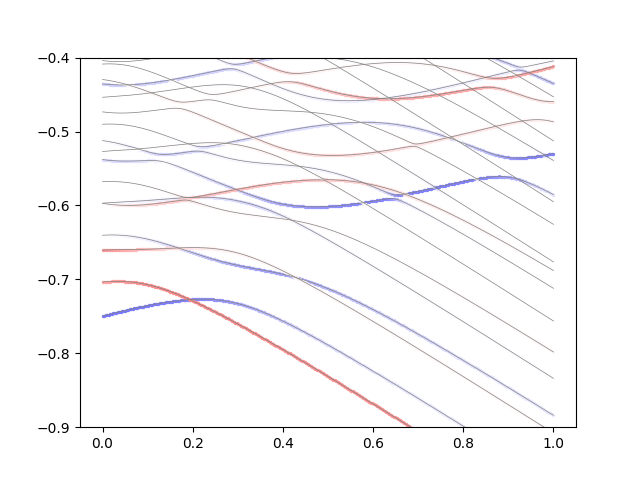

In [85]:
def color_map_blue(norm_val):
    return (1-np.exp(np.log(norm_val)),1-np.exp(np.log(norm_val)),1)
def color_map_red(norm_val):
    return (1,1-np.exp(np.log(norm_val)),1-np.exp(np.log(norm_val)))
plt.close()
plt.figure(1)
x = p['E_td_00']/1e3
plt.plot(x,(E0-2*p['Bv'])/1e3,color='gray',linewidth=0.5)
for i,xx in enumerate(x):
    dm_this = dm_val[1][i,:] # pi polarization for now
    inds = np.argwhere(np.abs(dm_this) > 0.001)
    for j in inds:
        plt.scatter(xx,(E0[i,j]-2*p['Bv'])/1e3,color=color_map_blue(np.abs(dm_this)[j][0]),s=2)
for i,xx in enumerate(x):
    dm_this = dm_val[0][i,:] # sig polarization
    inds = np.argwhere(np.abs(dm_this) > 0.001)
    for j in inds:
        plt.scatter(xx,(E0[i,j]-2*p['Bv'])/1e3,color=color_map_red(np.abs(dm_this)[j][0]),s=2)        
plt.ylim(-.9,-.4)



(-0.9, -0.4)

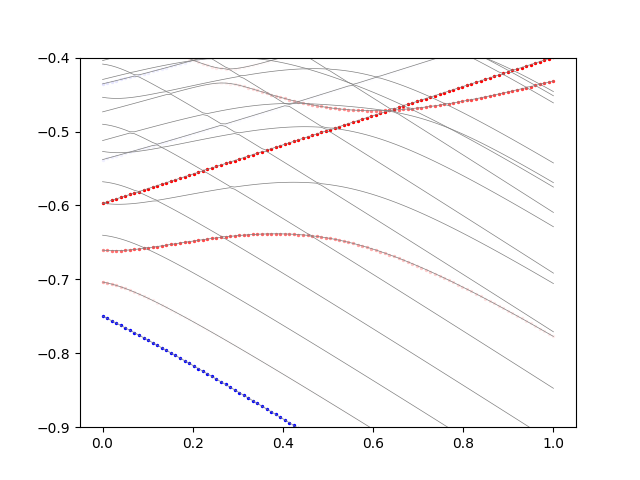

In [90]:
p = p0.copy()
p['E_td_00'] = np.linspace(0,1000,100)
p['B'] = np.linspace(181.5,181.5,1)
p['trap_pol'] = np.array([[0],[0],[1]])
# p['alpha_p'] = np.arccos(1/3)/2
H_B,b_uc = H_mol(p)

E0, Ev0 = calc_eig(H_B)


def calc_uwave_vals(E,Ev,b_uc,ss):
    
    def map2roteig(Tv, b_uc):
        inds = np.zeros(Tv.shape[0])
        for j in range(Tv.shape[0]):
            v = Tv[:,j]
            v_amp = np.abs(v)
            ind = np.argmax(v_amp)
            if b_uc.v.loc[ind,'m_n'] == 0:
                inds[j] = 0
            elif b_uc.v.loc[ind,'m_n'] == 1 or b_uc.v.loc[ind,'m_n'] == -1:
                v_amp[ind] = 0
                ind2 = np.argmax(v_amp)
                if np.sign(v[ind])*np.sign(v[ind2]) > 0:
                    inds[j] = 1
                else:
                    inds[j] = -1
        return inds
    
    sind = disp_vec(b_uc, Ev[0], ss, b_print=False)    
    
    H_dm_uc = dm_ops_sph(b_uc)
    H_dm_v_all = []
    for i in range(3):
        H_dm_v = np.zeros(Ev.shape[0:2])
        for n, vv in enumerate(Ev):
            H_dm_v[n,:] = (np.transpose(vv)@H_dm_uc[i]@vv)[sind,:]
        H_dm_v_all.append(H_dm_v)

    return H_dm_v_all # H_dm_v[:][sind,:]

def color_map_blue(norm_val):
    return (1-np.exp(np.log(norm_val)),1-np.exp(np.log(norm_val)),1)
def color_map_red(norm_val):
    return (1,1-np.exp(np.log(norm_val)),1-np.exp(np.log(norm_val)))

dm_val = calc_uwave_vals(E0,Ev0,b_uc,[['m_i1',1.5],['m_i2',3.5],['n',0],['m_n',0]])
    
plt.close()
plt.figure(1)
x = p['E_td_00']/1e3
plt.plot(x,(E0-2*p['Bv'])/1e3,color='gray',linewidth=0.5)
for i,xx in enumerate(x):
    dm_this = np.abs(dm_val[1][i,:])**2 # pi polarization for now
    dm_this = dm_this / np.max(dm_this)
    inds = np.argwhere(np.abs(dm_this) > 0.001)
    for j in inds:
        plt.scatter(xx,(E0[i,j]-2*p['Bv'])/1e3,color=color_map_blue(np.abs(dm_this)[j][0]),s=2)
for i,xx in enumerate(x):
#     dm_this = dm_val[0][i,:] # sig polarization
    dd = np.abs(dm_val[0][i,:])**2+np.abs(dm_val[2][i,:])**2
    dd = dd / np.max(dd)
    inds = np.argwhere(dd > 0.001)
    for j in inds:
        plt.scatter(xx,(E0[i,j]-2*p['Bv'])/1e3,color=color_map_red(np.abs(dd)[j][0]),s=2)        
plt.ylim(-.9,-.4)



In [30]:
inds

array([], shape=(1, 0), dtype=int64)

In [29]:
j

array([], dtype=int64)

In [10]:
Ev0.shape

(30, 128, 128)

In [ ]:
def calc_uwave(E,Ev,b_uc,ss):
    
    def map2roteig(Tv, b_uc):
        inds = np.zeros(Tv.shape[0])
        for j in range(Tv.shape[0]):
            v = Tv[:,j]
            v_amp = np.abs(v)
            ind = np.argmax(v_amp)
            if b_uc.v.loc[ind,'m_n'] == 0:
                inds[j] = 0
            elif b_uc.v.loc[ind,'m_n'] == 1 or b_uc.v.loc[ind,'m_n'] == -1:
                v_amp[ind] = 0
                ind2 = np.argmax(v_amp)
                if np.sign(v[ind])*np.sign(v[ind2]) > 0:
                    inds[j] = 1
                else:
                    inds[j] = -1
        return inds
    
    sind = disp_vec(b_uc, Ev0, ss)    
    
    H_dm_uc = dm_ops_sph(b_uc)
    H_dm_v = []
    for i in range(3):
        H_dm_v.append(np.transpose(Ev)@H_dm_uc[i]@Ev)
                
    thresh = 0.00001
    all_ind = np.array([],dtype=np.int8)
    all_ind_uc = np.array([],dtype=np.int8)
    vals = np.empty([3],dtype=np.int8)
    vals_norm = np.array([],dtype=np.int8)
    pols = ['sig-','pi','sig+']
    trans_type = []

    mat_el = (H_dm_v[0][sind,:]**2+H_dm_v[1][sind,:]**2+H_dm_v[2][sind,:]**2)
    ind = (np.argwhere(np.abs(mat_el) > thresh))
    all_ind = np.append(all_ind,ind)
    all_ind_uc = np.append(all_ind_uc,get_max_ind(Ev[:,ind]))    
    mat_el_all = np.array([H_dm_v[0][sind,:],H_dm_v[1][sind,:],H_dm_v[2][sind,:]])
    for i in ind:
        vals = np.vstack([vals, np.squeeze(mat_el_all[:,i])])
        vals_norm = np.append(vals_norm,mat_el[i])
    vals = vals[1:,:]
    
    rot_inds = map2roteig(Ev, b_uc)

    df = b_uc.v.loc[all_ind_uc,['m_i1','m_i2','n','m_n']]
    # df['m_n'] = df['m_n']
    df['mF'] = df[['m_i1','m_i2','m_n']].sum(axis=1)
#     df['rot'] = pd.Series(rot_inds)
    df[['sig-','pi','sig+']] = pd.DataFrame(index=df.index,data=vals).applymap('{:,.5f}'.format)
    df['mat_el_abs'] = np.abs(vals_norm)
    # pols = ['sig-','pi','sig+']
    #df['pol'] = trans_type

    
    df['E [kHz]'] = E[0,all_ind] - E[0,all_ind[0]]
    df['rot'] = rot_inds[all_ind]
    df['v_ind'] = all_ind
    print(df.sort_values(['mat_el_abs'],ascending=False).drop(['mat_el_abs'],axis=1))
    #df['cost'] = df['cost'].map('${:,.2f}'.format)
    #print(df)


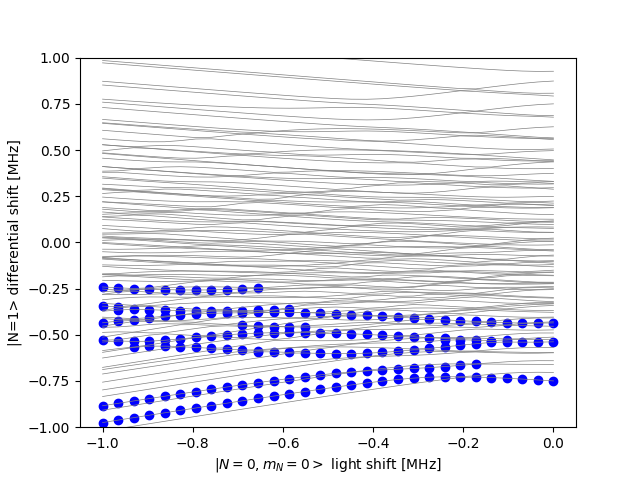

In [292]:
def choose_mF(E,Ev,b_uc,mF_val):
#     _, inds = map2basis(Ev)
#     E_mF = []
#     for i,idd in enumerate(inds):
#         df = b_uc.v.loc[idd,['m_i1','m_i2','n','m_n']]
#         mF = df[['m_i1','m_i2','m_n']].sum(axis=0)
#         if mF == mF_val:
#             E_mF.append(E[i])
    E_mF = []
#     for i,v in enumerate(np.transpose(Ev)):
    for i in range(Ev.shape[0]):
        v = Ev[:,i]
        inds = np.argwhere(np.abs(v)>0.3)
        for j in inds.flatten():
            df = b_uc.v.loc[j,['m_i1','m_i2','n','m_n']]
            mF = df[['m_i1','m_i2','m_n']].sum(axis=0)    
#             print(mF)
            if mF == mF_val:
                E_mF.append(E[i])
                continue
#     print(np.unique(np.array(E_mF)))
    return np.unique(np.array(E_mF))

plt.close()
plt.figure(1)
x = p['E_td_00']/1e3
plt.plot(x,(E0-2*p['Bv'])/1e3,color='gray',linewidth=0.5)
# pt_gs = ax2.plot(B0,Egs-2*Bv,color='blue',linewidth=0.5)
plt.ylim(-1,1)
plt.xlabel('$|N=0,m_N=0>$ light shift [MHz]')
plt.ylabel('|N=1> differential shift [MHz]')

for i, EE in enumerate(E0):
    Ethis = choose_mF(EE,Ev0[i,:,:],b_uc,5)
#     print(Ethis.shape)
    for Eii in Ethis:
        plt.scatter(x[i],(Eii-2*p['Bv'])/1e3,color='blue')


All the states have linear dependence in trap depth. So have roughly 1-2MHz with 5MHz trap depth for $|N=0,m_N=0>$, ie ~20%. With say 1% intensity fluctuation, that would correspond to 10kHz fluctuation.

In [328]:
2*p['Bv']

980346.0

In [319]:
p['muE']

629.2643913526935

In [344]:
p = p0.copy()
p['E_td_00'] = np.linspace(0,1000,30)
p['B'] = np.linspace(181.5,181.5,1)
p['trap_pol'] = np.array([[0],[0],[1]])
p['E_dc'] = np.array([0,0,300])
H_B,b_uc = H_mol(p)

E0, Ev0 = calc_eig(H_B)

Text(0, 0.5, '|N=1> differential shift [MHz]')

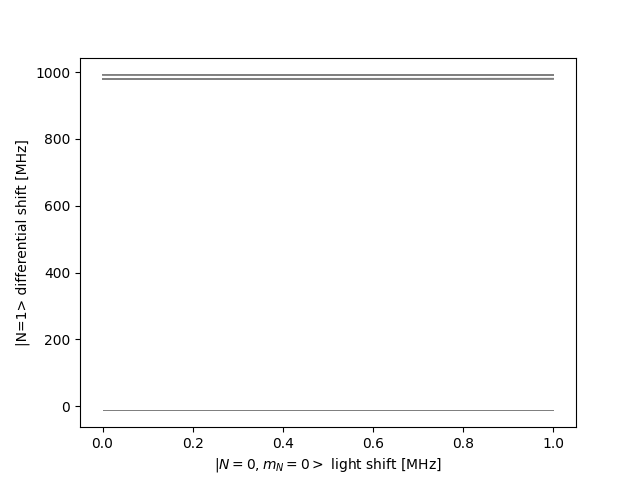

In [343]:
plt.close()
plt.figure(1)
x = p['E_td_00']/1e3
# plt.plot(x,(E0-2*p['Bv'])/1e3,color='gray',linewidth=0.5)
plt.plot(x,(E0)/1e3,color='gray',linewidth=0.5)
# pt_gs = ax2.plot(B0,Egs-2*Bv,color='blue',linewidth=0.5)
# plt.ylim(-.9,.9)
plt.xlabel('$|N=0,m_N=0>$ light shift [MHz]')
plt.ylabel('|N=1> differential shift [MHz]')

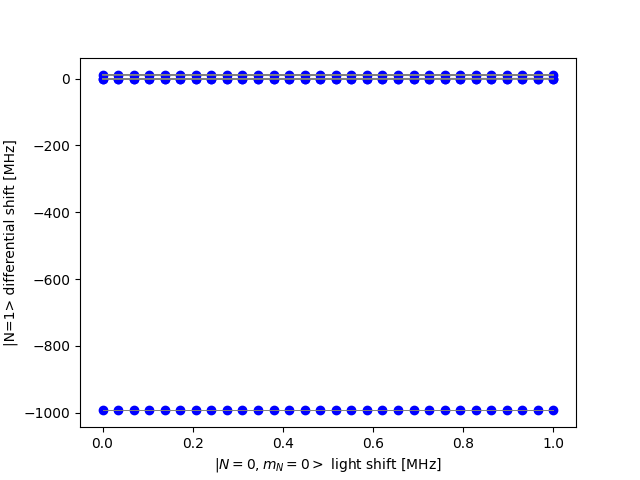

In [346]:
def choose_mF(E,Ev,b_uc,mF_val):
#     _, inds = map2basis(Ev)
#     E_mF = []
#     for i,idd in enumerate(inds):
#         df = b_uc.v.loc[idd,['m_i1','m_i2','n','m_n']]
#         mF = df[['m_i1','m_i2','m_n']].sum(axis=0)
#         if mF == mF_val:
#             E_mF.append(E[i])
    E_mF = []
#     for i,v in enumerate(np.transpose(Ev)):
    for i in range(Ev.shape[0]):
        v = Ev[:,i]
        inds = np.argwhere(np.abs(v)>0.3)
        for j in inds.flatten():
            df = b_uc.v.loc[j,['m_i1','m_i2','n','m_n']]
            mF = df[['m_i1','m_i2','m_n']].sum(axis=0)    
#             print(mF)
            if mF == mF_val:
                E_mF.append(E[i])
                continue
#     print(np.unique(np.array(E_mF)))
    return np.unique(np.array(E_mF))

plt.close()
plt.figure(1)
x = p['E_td_00']/1e3
plt.plot(x,(E0-2*p['Bv'])/1e3,color='gray',linewidth=0.5)
# pt_gs = ax2.plot(B0,Egs-2*Bv,color='blue',linewidth=0.5)
# plt.ylim(-1,1)
plt.xlabel('$|N=0,m_N=0>$ light shift [MHz]')
plt.ylabel('|N=1> differential shift [MHz]')

for i, EE in enumerate(E0):
    Ethis = choose_mF(EE,Ev0[i,:,:],b_uc,5)
#     print(Ethis.shape)
    for Eii in Ethis:
        plt.scatter(x[i],(Eii-2*p['Bv'])/1e3,color='blue')


#### Microwave transfer pathways with linearly polarized trap (5 MHz)

In [10]:
p = p0.copy()
p['E_td_00'] = np.linspace(5000,5000,1)
p['B'] = np.linspace(866,866,1)
# p['trap_gamma'] = np.arccos(1/3)/2
H_B,b_uc = H_mol(p)

E0, Ev0 = calc_eig(H_B)

In [11]:
calc_uwave(E0,Ev0,b_uc,[['m_i1',1.5],['m_i2',2.5],['n',0],['m_n',0]])

Ev index: 29
     m_i1  m_i2    n  m_n      amps
120   1.5   2.5  0.0  0.0  0.999821
92    0.5   3.5  0.0  0.0 -0.018945
     m_i1  m_i2    n  m_n   mF      sig-        pi      sig+      E [kHz]  rot  v_ind
123   1.5   2.5  1.0  1.0  5.0  -0.40792   0.00000  -0.40850  3487.604205  1.0     83
122   1.5   2.5  1.0  0.0  4.0  -0.00000  -0.57716  -0.00000   471.943020  0.0     47
121   1.5   2.5  1.0 -1.0  3.0   0.40845  -0.00000  -0.40773   483.028470 -1.0     33
125   1.5   3.5  1.0 -1.0  4.0  -0.00000  -0.01174  -0.00000    -8.078375 -1.0     41
118   1.5   1.5  1.0  0.0  3.0   0.00651   0.00000  -0.00941   948.065096  0.0     39
126   1.5   3.5  1.0  0.0  5.0  -0.00549   0.00000   0.00724     0.000000  0.0     30
117   1.5   1.5  1.0 -1.0  2.0  -0.00000   0.00712  -0.00000   971.990520 -1.0     52
90    0.5   2.5  1.0  0.0  3.0   0.00172   0.00000  -0.00487  1456.832341  0.0     49
57   -0.5   2.5  1.0 -1.0  1.0   0.00137  -0.00000   0.00494  2404.119118 -1.0     68
113   1.5   0.5  1.

Up-leg $\pi$-transition 

In [12]:
calc_uwave(E0,Ev0,b_uc,[['m_i1',1.5],['m_i2',2.5],['n',1],['m_n',0]])

Ev index: 47
     m_i1  m_i2    n  m_n      amps
122   1.5   2.5  1.0  0.0 -0.999513
94    0.5   3.5  1.0  0.0  0.017629
127   1.5   3.5  1.0  1.0  0.017031
125   1.5   3.5  1.0 -1.0 -0.011627
     m_i1  m_i2    n  m_n   mF      sig-        pi      sig+      E [kHz]  rot  v_ind
120   1.5   2.5  0.0  0.0  4.0   0.00000  -0.57716   0.00000  -965.406130  0.0     29
124   1.5   3.5  0.0  0.0  5.0  -0.00983   0.00000   0.00671 -1449.989266  0.0    127
116   1.5   1.5  0.0  0.0  3.0  -0.00581  -0.00000   0.00436  -480.771686  0.0     27
88    0.5   2.5  0.0  0.0  3.0   0.00440   0.00000  -0.00268     0.000000  0.0     26


In [13]:
disp_vec(b_uc, Ev0, [['m_i1',1.5],['m_i2',3.5],['n',0],['m_n',0]])    

Ev index: 127
     m_i1  m_i2    n  m_n  amps
124   1.5   3.5  0.0  0.0   1.0


127

Up-leg $\sigma$-transition

In [14]:
calc_uwave(E0,Ev0,b_uc,83)

Ev index: 83
     m_i1  m_i2    n  m_n      amps
123   1.5   2.5  1.0  1.0 -0.707403
121   1.5   2.5  1.0 -1.0 -0.706411
95    0.5   3.5  1.0  1.0  0.013784
93    0.5   3.5  1.0 -1.0  0.013767
     m_i1  m_i2    n  m_n   mF      sig-       pi     sig+     E [kHz]  rot  v_ind
120   1.5   2.5  0.0  0.0  4.0   0.40850  0.00000  0.40792 -969.318928  0.0     29
56   -0.5   2.5  0.0  0.0  2.0  -0.00139  0.00000  0.00495  961.417635  0.0     23
112   1.5   0.5  0.0  0.0  2.0   0.00155  0.00000  0.00445    0.000000  0.0      8


In [15]:
calc_uwave(E0,Ev0,b_uc,33)

Ev index: 33
     m_i1  m_i2    n  m_n      amps
121   1.5   2.5  1.0 -1.0  0.707318
123   1.5   2.5  1.0  1.0 -0.706077
118   1.5   1.5  1.0  0.0 -0.019324
126   1.5   3.5  1.0  0.0  0.015589
93    0.5   3.5  1.0 -1.0 -0.013844
95    0.5   3.5  1.0  1.0  0.013728
     m_i1  m_i2    n  m_n   mF      sig-        pi      sig+      E [kHz]  rot  v_ind
120   1.5   2.5  0.0  0.0  4.0   0.40773  -0.00000  -0.40845  -969.318928  0.0     29
116   1.5   1.5  0.0  0.0  3.0  -0.00000   0.01128   0.00000  -484.684485  0.0     27
124   1.5   3.5  0.0  0.0  5.0   0.00000   0.00900  -0.00000 -1453.902065  0.0    127
88    0.5   2.5  0.0  0.0  3.0   0.00000  -0.00495  -0.00000    -3.912798  0.0     26
112   1.5   0.5  0.0  0.0  2.0  -0.00371  -0.00000   0.00225     0.000000  0.0      8


#### With optimal elliptical polarization
Since we only have the option of polarization in xy-plane (no $\pi$), use the matrix elements with elliptical polarization. Magic angle is given by $\cos(2\gamma)=1/3$.

In [17]:
p = p0.copy()
p['E_td_00'] = np.linspace(0,5000,100)
p['B'] = np.linspace(866,866,1)
p['trap_gamma'] = np.arccos(1/3)/2
H_B,b_uc = H_mol(p)

E0, Ev0 = calc_eig(H_B)

Text(0, 0.5, '|N=1> differential shift [MHz]')

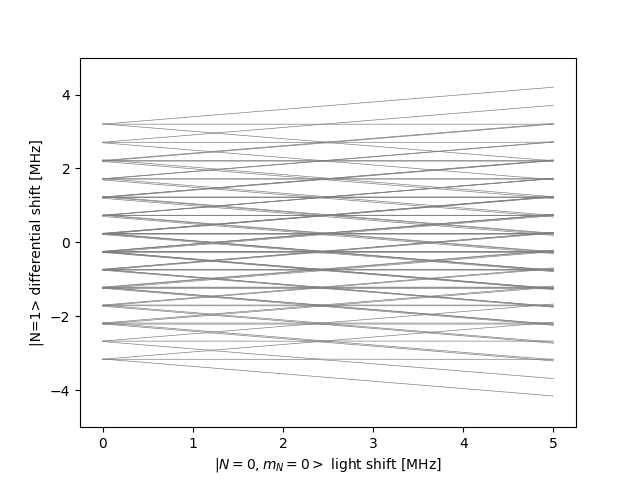

In [17]:
plt.close()
plt.figure(1)
x = p['E_td_00']/1e3
plt.plot(x,(E0-2*p['Bv'])/1e3,color='gray',linewidth=0.5)
# pt_gs = ax2.plot(B0,Egs-2*Bv,color='blue',linewidth=0.5)
plt.ylim(-5,5)
plt.xlabel('$|N=0,m_N=0>$ light shift [MHz]')
plt.ylabel('|N=1> differential shift [MHz]')

The differential light shift of states $\propto |1,1>-|1,-1>$ are flat.

#### Microwave pathways with optimal polarization

In [18]:
p = p0.copy()
p['E_td_00'] = np.linspace(0,0,1)
p['B'] = np.linspace(181.5,181.5,1)
# p['trap_gamma'] = np.arccos(1/3)/2
H_B,b_uc = H_mol(p)

E0, Ev0 = calc_eig(H_B)

In [19]:
calc_uwave(E0,Ev0,b_uc,[['m_i1',1.5],['m_i2',3.5],['n',0],['m_n',0]])

Ev index: 126
     m_i1  m_i2    n  m_n  amps
124   1.5   3.5  0.0  0.0   1.0
     m_i1  m_i2    n  m_n   mF      sig-        pi     sig+     E [kHz]  rot  v_ind
127   1.5   3.5  1.0  1.0  6.0   0.00000   0.00000  0.57735  152.445271 -1.0    127
126   1.5   3.5  1.0  0.0  5.0  -0.00000  -0.53376  0.00000    0.000000  0.0      0
125   1.5   3.5  1.0 -1.0  4.0   0.39340  -0.00000  0.00000   89.119179  1.0     38
122   1.5   2.5  1.0  0.0  4.0  -0.33980   0.00000  0.00000   45.999571  0.0     37
63   -0.5   3.5  1.0  1.0  4.0  -0.22076  -0.00000  0.00000  526.454837  1.0     76
95    0.5   3.5  1.0  1.0  5.0  -0.00000  -0.17518  0.00000  314.073808  1.0      2
123   1.5   2.5  1.0  1.0  5.0  -0.00000   0.13323  0.00000  211.613245 -1.0      1
94    0.5   3.5  1.0  0.0  4.0   0.11907   0.00000  0.00000  428.811394  0.0     64
91    0.5   2.5  1.0  1.0  4.0   0.01069   0.00000  0.00000  380.700610 -1.0     58
119   1.5   1.5  1.0  1.0  4.0   0.00894  -0.00000  0.00000  276.173909 -1.0     4

We want the "-1" state for the rotational state.

In [22]:
E0.shape

(1, 128)

In [20]:
calc_uwave(E0,Ev0,b_uc,34)

Ev index: 34
     m_i1  m_i2    n  m_n      amps
123   1.5   2.5  1.0  1.0  0.681910
121   1.5   2.5  1.0 -1.0 -0.681814
90    0.5   2.5  1.0  0.0  0.263999
95    0.5   3.5  1.0  1.0 -0.010649
118   1.5   1.5  1.0  0.0 -0.010061
     m_i1  m_i2    n  m_n   mF      sig-        pi      sig+     E [kHz]  rot  v_ind
120   1.5   2.5  0.0  0.0  4.0   0.39375  -0.00000  -0.39367 -969.318928  0.0     30
88    0.5   2.5  0.0  0.0  3.0   0.00000   0.15227  -0.00000   -3.912798  0.0     26
116   1.5   1.5  0.0  0.0  3.0  -0.00000  -0.00956   0.00000 -484.684485  0.0     27
112   1.5   0.5  0.0  0.0  2.0   0.00438   0.00000  -0.00149    0.000000  0.0     12


In [281]:
cc

array([[[[-1,  2],
         [ 3,  1]],

        [[ 5,  6],
         [ 7,  8]]],


       [[[10, 12],
         [14, 16]],

        [[ 3,  6],
         [ 9, 12]]]])

In [282]:
np.fill_diagonal(cc[0,0],np.diagonal(cc[0,0])-1)
cc

array([[[[-2,  2],
         [ 3,  0]],

        [[ 5,  6],
         [ 7,  8]]],


       [[[10, 12],
         [14, 16]],

        [[ 3,  6],
         [ 9, 12]]]])

In [270]:
np.diagonal(cc)

array([[[-1,  3],
        [ 2,  6]],

       [[ 3,  9],
        [ 1, 12]]])

In [271]:
cc

array([[[[-1,  2],
         [ 3,  1]],

        [[ 5,  6],
         [ 7,  8]]],


       [[[10, 12],
         [14, 16]],

        [[ 3,  6],
         [ 9, 12]]]])

In [272]:
np.einsum('ijkl->klij',cc)

array([[[[-1,  5],
         [10,  3]],

        [[ 2,  6],
         [12,  6]]],


       [[[ 3,  7],
         [14,  9]],

        [[ 1,  8],
         [16, 12]]]])

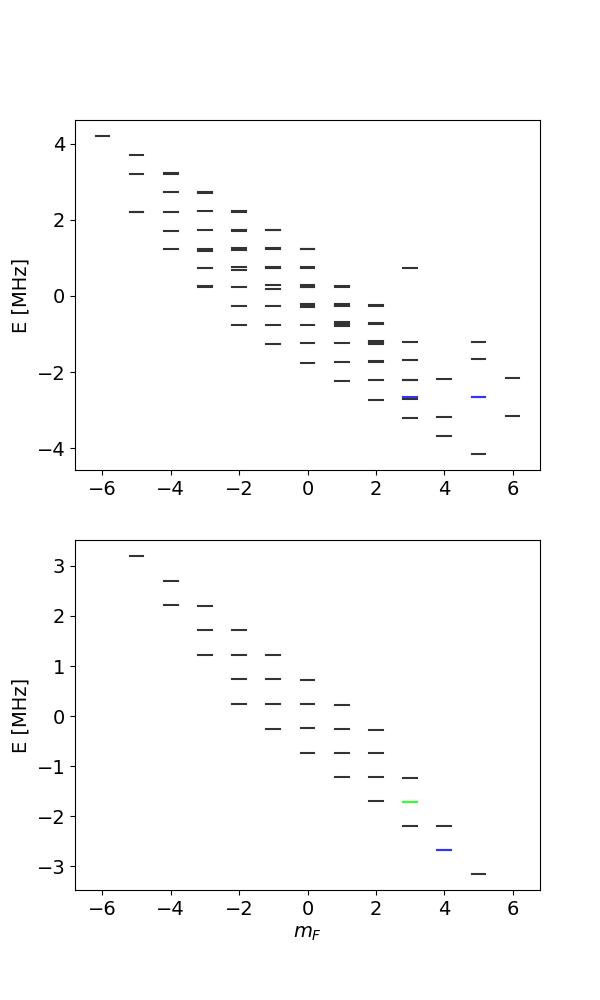

In [35]:
def plot_mf(E, Ev, b_uc, p):
    
    M_vind2uc, inds_vind2uc = map2basis(Ev)    
    plt.rcParams.update({'font.size': 14, 'font.weight' : 'normal',})

    EE = E / 1e3

    la = 0.2
    _, ax = plt.subplots(2, 1, figsize=(6,10))
    for i in range(EE.shape[1]):
        m_f = b_uc.v.loc[inds_vind2uc[i],['m_i1','m_i2','m_n']].sum()
        if E[0,i] < 1000e3:
            ax[1].plot([m_f-la,m_f+la],[EE[0,i],EE[0,i]],color=[0.2,0.2,0.2])
        else:
            ax[0].plot([m_f-la,m_f+la],[EE[0,i]-2*p['Bv']/1e3,EE[0,i]-2*p['Bv']/1e3],color=[0.2,0.2,0.2])     
           
        # initial state
        if i == 30:
            ax[1].plot([m_f-la,m_f+la],[EE[0,i],EE[0,i]],color=[0.2,0.2,1])
        
#         # pi up sig down
#         if inds_vind2uc[i] == 124 or inds_vind2uc[i] == 116:
#             ax[1].plot([m_f-la,m_f+la],[E[0,i],E[0,i]],color=[0.2,1,0.2])     
#         if i == 47:
#             ax[0].plot([m_f-la,m_f+la],[E[0,i]-2*p['Bv'],E[0,i]-2*p['Bv']],color=[0.2,1,0.2])    
            
        # sig up pi down
        if i == 34:
            ax[0].plot([m_f-la,m_f+la],[EE[0,i]-2*p['Bv']/1e3,EE[0,i]-2*p['Bv']/1e3],color=[0.2,0.2,1])
            ax[0].plot([m_f-la-2,m_f+la-2],[EE[0,i]-2*p['Bv']/1e3,EE[0,i]-2*p['Bv']/1e3],color=[0.2,0.2,1])
        if i == 26: # inds_vind2uc[i] == 116 or inds_vind2uc[i] == 124:
            ax[1].plot([m_f-la,m_f+la],[EE[0,i],EE[0,i]],color=[0.2,1,0.2])          
            
            
#        if i in all_ind:
#            ax[0].plot([m_f-la,m_f+la],[E[i],E[i]],color=[1,0.2,0.2])
#     for i in range(E.shape[0]):        
#         m_f = b_uc.v.loc[inds_vind2uc[i],['m_i1','m_i2','m_n']].sum()    
#         if inds_vind2uc[i] in [119,121,125]:
#             #ax[0].subplot(2,1,1)        
#             ax[0].plot([m_f-la,m_f+la],[E[i],E[i]],color=[0,1,0])


    ax[0].set_xlim([-6.8,6.8])
    ax[0].set_ylabel('E [MHz]')
    ax[1].set_ylabel('E [MHz]')
    ax[1].set_xlim([-6.8,6.8])
    plt.xlabel('$m_F$')

plot_mf(E0, Ev0, b_uc, p)    

In [103]:
aa = np.array([[1,2],[3,4]])
bb = np.array([[5,6],[7,8]])
cc = np.array([[aa,bb],[bb*2,aa*3]])
               

In [113]:
cc@np.array([[1],[-2]])

array([[[[ -3],
         [ -5]],

        [[ -7],
         [ -9]]],


       [[[-14],
         [-18]],

        [[ -9],
         [-15]]]])

In [205]:
pp = np.array([[1,1j]])

In [210]:
pp@np.conjugate(pp.T)

array([[2.+0.j]])

In [214]:
np.linalg.norm(pp)

1.4142135623730951

In [153]:
dd = np.array([[1],[-2]])
ee = np.array([[1,-2]])

In [127]:
np.einsum('',cc,dd)

ValueError: operand has more dimensions than subscripts given in einstein sum, but no '...' ellipsis provided to broadcast the extra dimensions.

In [128]:
np.einsum('ij,jk->ik',aa,bb)

array([[19, 22],
       [43, 50]])

In [145]:
np.einsum('ij,jk->ik',aa,dd)

array([[1],
       [3]])

In [198]:
kk = np.einsum('ijkl,jm->ikl',cc,dd)

In [199]:
kk

array([[[ -9, -10],
        [-11, -12]],

       [[  4,   0],
        [ -4,  -8]]])

In [203]:
np.einsum('ij,jlm->ilm',ee,kk)

array([[[-17, -10],
        [ -3,   4]]])

In [200]:
ee

array([[ 1, -2]])

In [202]:
kk.shape

(2, 2, 2)

In [165]:
cc[0,1]

array([[5, 6],
       [7, 8]])

In [171]:
ee

array([[ 1, -2]])

In [172]:
dd

array([[ 1],
       [-2]])

In [173]:
dd.shape

(2, 1)

In [185]:
cc

array([[[[ 1,  2],
         [ 3,  4]],

        [[ 5,  6],
         [ 7,  8]]],


       [[[10, 12],
         [14, 16]],

        [[ 3,  6],
         [ 9, 12]]]])

In [197]:
dd.shape == (3,1)

False

In [187]:
cc[0,1]

array([[5, 6],
       [7, 8]])